In [18]:
# bank_churn_prediction.ipynb

# 1. Importações necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [19]:
# 2. Carregar o dataset
df = pd.read_csv('playground-series-s4e1/train.csv')

In [20]:
# 3. Análise inicial
print("\nPrimeiras linhas do dataset:")
print(df.head())

print("\nInformações gerais do dataset:")
print(df.info())

print("\nNúmero de valores nulos por coluna:")
print(df.isnull().sum())

print("\nDescrição estatística do dataset:")
print(df.describe())



Primeiras linhas do dataset:
   id  CustomerId         Surname  CreditScore Geography Gender   Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male  33.0       3   
1   1    15749177   Okwudiliolisa          627    France   Male  33.0       1   
2   2    15694510           Hsueh          678    France   Male  40.0      10   
3   3    15741417             Kao          581    France   Male  34.0       2   
4   4    15766172       Chiemenam          716     Spain   Male  33.0       5   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              2        1.0             0.0        181449.97   
1       0.00              2        1.0             1.0         49503.50   
2       0.00              2        1.0             0.0        184866.69   
3  148882.54              1        1.0             1.0         84560.88   
4       0.00              2        1.0             1.0         15068.83   

   Exited  
0       0  
1       

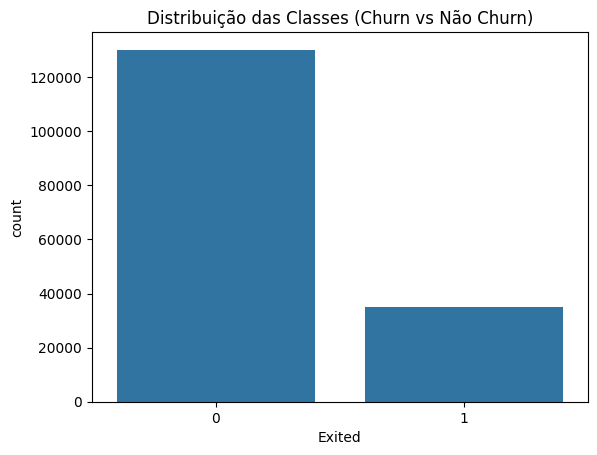

In [21]:
# 4. Gráfico da distribuição da variável alvo
sns.countplot(x='Exited', data=df)
plt.title('Distribuição das Classes (Churn vs Não Churn)')
plt.show()

In [22]:
# 5. Codificar variáveis categóricas
if 'Gender' in df.columns:
    labelencoder = LabelEncoder()
    df['Gender'] = labelencoder.fit_transform(df['Gender'])

if 'Geography' in df.columns:
    labelencoder = LabelEncoder()
    df['Geography'] = labelencoder.fit_transform(df['Geography'])

In [23]:
# 6. Separar Features (X) e Target (y)
X = df.drop(['Exited'], axis=1)
y = df['Exited']

In [24]:
# 7. Remover colunas não numéricas
X = X.select_dtypes(include=[np.number])

In [25]:
# 8. Normalizar as Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
# 9. Separar em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


Distribuição original das classes:
Exited
0    90980
1    24543
Name: count, dtype: int64

Distribuição após SMOTE + Undersampling:
Exited
0    56862
1    45490
Name: count, dtype: int64


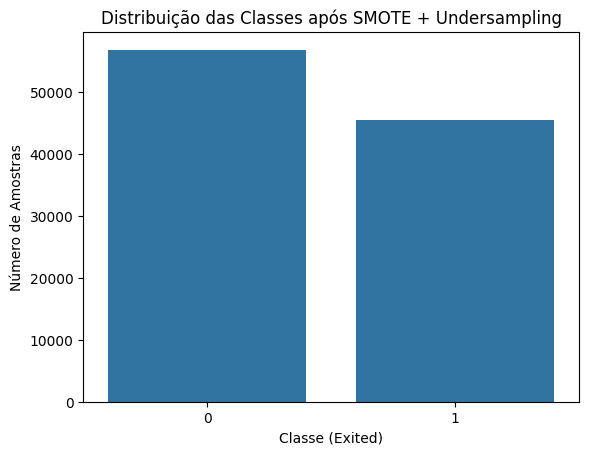

In [32]:
# 9b. Rebalanceamento com SMOTE + RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Ver distribuição original
print("Distribuição original das classes:")
print(y_train.value_counts())

# Definir estratégia: aumentar classe 1 com SMOTE e reduzir ligeiramente classe 0
over = SMOTE(sampling_strategy=0.5, random_state=42)  # Classe 1 = 50% da classe 0
under = RandomUnderSampler(sampling_strategy=0.8, random_state=42)  # Classe 0 reduzida para 80% da nova classe 1
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Aplicar ao treino
X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train, y_train)

# Ver nova distribuição
print("\nDistribuição após SMOTE + Undersampling:")
print(pd.Series(y_train_balanced).value_counts())

# Gráfico atualizado
sns.countplot(x=y_train_balanced)
plt.title('Distribuição das Classes após SMOTE + Undersampling')
plt.xlabel('Classe (Exited)')
plt.ylabel('Número de Amostras')
plt.show()


In [33]:
# 10. GridSearchCV para Decision Tree
"""param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
start_train_dt = time.time()
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train_balanced, y_train_balanced)
end_train_dt = time.time()
best_dt = grid_dt.best_estimator_
start_test_dt = time.time()
y_pred_dt = best_dt.predict(X_test)
end_test_dt = time.time()""" 

# === 10. Decision Tree com dados balanceados ===
param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
start_train_dt = time.time()
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train_balanced, y_train_balanced)  # Treino com dados balanceados
end_train_dt = time.time()

best_dt = grid_dt.best_estimator_

start_test_dt = time.time()
y_pred_dt = best_dt.predict(X_test)  # Avaliação nos dados originais
end_test_dt = time.time()

In [34]:
# 11. GridSearchCV para k-NN
"""param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
start_train_knn = time.time()
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train, y_train)
end_train_knn = time.time()
best_knn = grid_knn.best_estimator_
start_test_knn = time.time()
y_pred_knn = best_knn.predict(X_test)
end_test_knn = time.time()"""

# === 11. k-NN com dados balanceados ===
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
start_train_knn = time.time()
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train_balanced, y_train_balanced)
end_train_knn = time.time()

best_knn = grid_knn.best_estimator_

start_test_knn = time.time()
y_pred_knn = best_knn.predict(X_test)
end_test_knn = time.time()

In [35]:
# 12. GridSearchCV para SVM
"""param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
start_train_svm = time.time()
grid_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)
end_train_svm = time.time()
best_svm = grid_svm.best_estimator_
start_test_svm = time.time()
y_pred_svm = best_svm.predict(X_test)
end_test_svm = time.time()"""  

"""# Amostra reduzida para treino rápido do tuning
X_train_small = X_train[:20000]
y_train_small = y_train[:20000]

# 12. RandomizedSearchCV para SVM (mais rápido)
param_dist_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
start_train_svm = time.time()
random_svm = RandomizedSearchCV(
    estimator=SVC(probability=False),
    param_distributions=param_dist_svm,
    n_iter=6,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)
random_svm.fit(X_train_small, y_train_small)
end_train_svm = time.time()

# Treino final com o melhor modelo e probability=True
best_svm = SVC(**random_svm.best_params_, probability=True)
start_final_train = time.time()
best_svm.fit(X_train, y_train)
end_final_train = time.time()

# Previsões
start_test_svm = time.time()
y_pred_svm = best_svm.predict(X_test)
end_test_svm = time.time()

# Tempos ajustados
train_time_svm = (end_train_svm - start_train_svm) + (end_final_train - start_final_train)
test_time_svm = end_test_svm - start_test_svm"""  

"""from sklearn.model_selection import train_test_split, RandomizedSearchCV


# Subconjunto dos dados só para tuning rápido
X_small, _, y_small, _ = train_test_split(X_train, y_train, train_size=20000, stratify=y_train, random_state=42)

# Novo grid de parâmetros com menos combinações
param_dist_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

start_train_svm = time.time()
random_svm = RandomizedSearchCV(SVC(), param_distributions=param_dist_svm, n_iter=6, cv=3, n_jobs=-1, scoring='accuracy', random_state=42)
random_svm.fit(X_small, y_small)
end_train_svm = time.time()

print("RandomizedSearchCV SVM concluído em %.2f segundos" % (end_train_svm - start_train_svm))
print("Melhores parâmetros SVM (random):", random_svm.best_params_)

# Treinar o melhor modelo com probabilidade ativada (necessário para ROC curve)
best_svm = SVC(**random_svm.best_params_, probability=True)
start_test_svm = time.time()
best_svm.fit(X_train, y_train)
y_pred_svm = best_svm.predict(X_test)
end_test_svm = time.time()"""

# === 12. SVM com dados balanceados ===
param_dist_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
start_train_svm = time.time()
random_svm = RandomizedSearchCV(SVC(probability=True), param_distributions=param_dist_svm,
                                n_iter=6, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
random_svm.fit(X_train_balanced, y_train_balanced)
end_train_svm = time.time()

best_svm = random_svm.best_estimator_

start_test_svm = time.time()
y_pred_svm = best_svm.predict(X_test)
end_test_svm = time.time()


In [36]:
# 13. Avaliação – Classification Report (Decision Tree)
"""print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))""" 

from sklearn.metrics import classification_report, confusion_matrix

print("\nDecision Tree Classification Report (Classe 1 = Churn):")
print(classification_report(y_test, y_pred_dt, target_names=["No Churn", "Churn"]))


Decision Tree Classification Report (Classe 1 = Churn):
              precision    recall  f1-score   support

    No Churn       0.92      0.86      0.89     39133
       Churn       0.58      0.73      0.64     10378

    accuracy                           0.83     49511
   macro avg       0.75      0.79      0.77     49511
weighted avg       0.85      0.83      0.84     49511



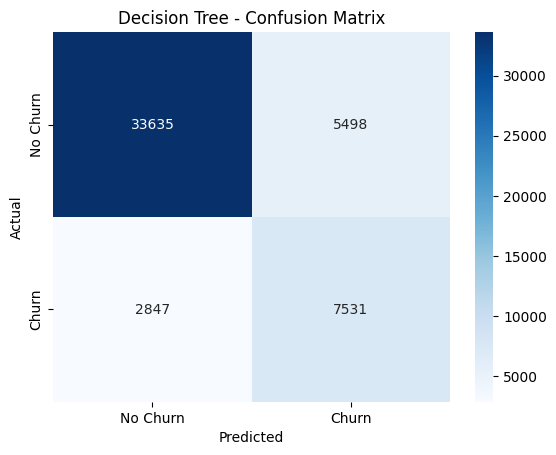

In [37]:
# 14. Matriz de Confusão – Decision Tree
"""sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree Confusion Matrix")
plt.show()"""

conf_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(conf_dt, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


k-NN Classification Report (Classe 1 = Churn):
              precision    recall  f1-score   support

    No Churn       0.91      0.81      0.85     39133
       Churn       0.49      0.68      0.57     10378

    accuracy                           0.78     49511
   macro avg       0.70      0.74      0.71     49511
weighted avg       0.82      0.78      0.79     49511



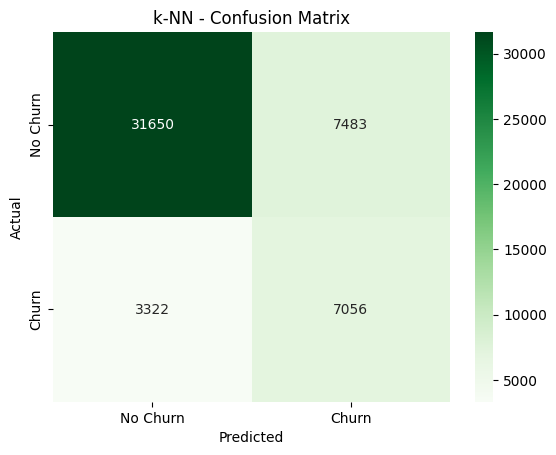

In [38]:
# 14a. Avaliação – k-NN
"""print("\nk-NN Classification Report:")
print(classification_report(y_test, y_pred_knn))

sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt="d", cmap="Greens")
plt.title("k-NN Confusion Matrix")
plt.show()"""

print("\nk-NN Classification Report (Classe 1 = Churn):")
print(classification_report(y_test, y_pred_knn, target_names=["No Churn", "Churn"]))

conf_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(conf_knn, annot=True, fmt="d", cmap="Greens", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title("k-NN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


SVM Classification Report (Classe 1 = Churn):
              precision    recall  f1-score   support

    No Churn       0.92      0.85      0.89     39133
       Churn       0.57      0.74      0.64     10378

    accuracy                           0.83     49511
   macro avg       0.75      0.80      0.77     49511
weighted avg       0.85      0.83      0.84     49511



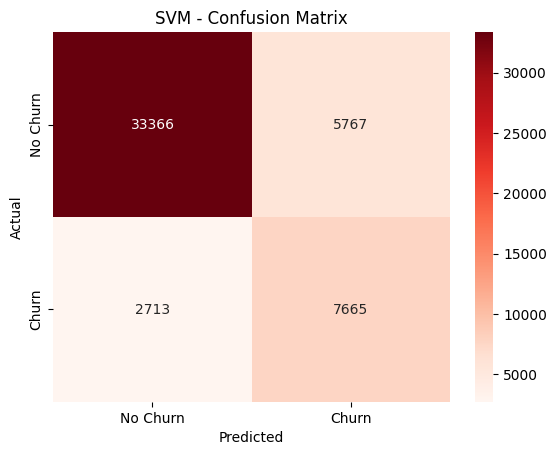

In [40]:
# 14b. Avaliação – SVM
"""print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt="d", cmap="Reds")
plt.title("SVM Confusion Matrix")
plt.show()"""

print("\nSVM Classification Report (Classe 1 = Churn):")
print(classification_report(y_test, y_pred_svm, target_names=["No Churn", "Churn"]))

conf_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_svm, annot=True, fmt="d", cmap="Reds", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [42]:
# 15. Acurácia dos modelos
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print("\nModel Accuracies after Hyperparameter Tuning:")
print(f"Decision Tree: {accuracy_dt:.4f}")
print(f"k-NN: {accuracy_knn:.4f}")
print(f"SVM: {accuracy_svm:.4f}")


Model Accuracies after Hyperparameter Tuning:
Decision Tree: 0.8315
k-NN: 0.7818
SVM: 0.8287


In [43]:
# 15a. Tempos de treino e teste
train_time_dt = end_train_dt - start_train_dt
test_time_dt = end_test_dt - start_test_dt
train_time_knn = end_train_knn - start_train_knn
test_time_knn = end_test_knn - start_test_knn
train_time_svm = end_train_svm - start_train_svm
test_time_svm = end_test_svm - start_test_svm

print("\nTraining and Testing Times (in seconds):")
print(f"Decision Tree - Train: {train_time_dt:.4f}s, Test: {test_time_dt:.4f}s")
print(f"k-NN           - Train: {train_time_knn:.4f}s, Test: {test_time_knn:.4f}s")
print(f"SVM            - Train: {train_time_svm:.4f}s, Test: {test_time_svm:.4f}s")


Training and Testing Times (in seconds):
Decision Tree - Train: 13.6841s, Test: 0.0080s
k-NN           - Train: 171.4508s, Test: 29.3930s
SVM            - Train: 72316.6334s, Test: 109.5600s


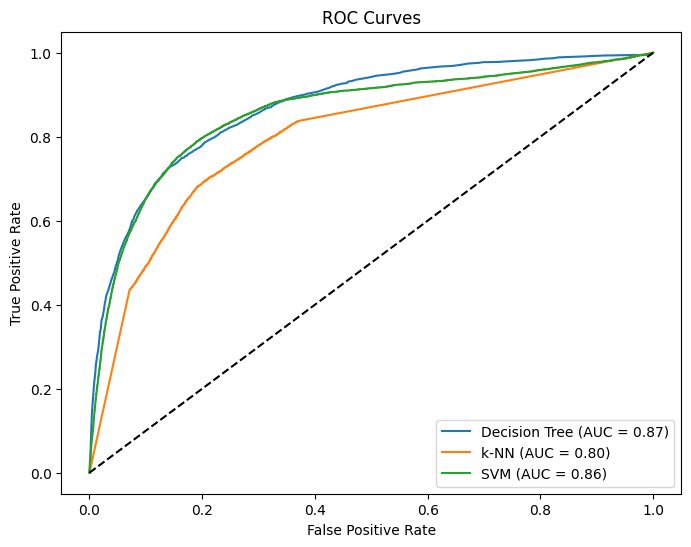

In [44]:
# 15b. Curvas ROC
# Decision Tree
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# k-NN
y_prob_knn = best_knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# SVM
y_prob_svm = best_svm.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, label='Decision Tree (AUC = %0.2f)' % roc_auc_dt)
plt.plot(fpr_knn, tpr_knn, label='k-NN (AUC = %0.2f)' % roc_auc_knn)
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

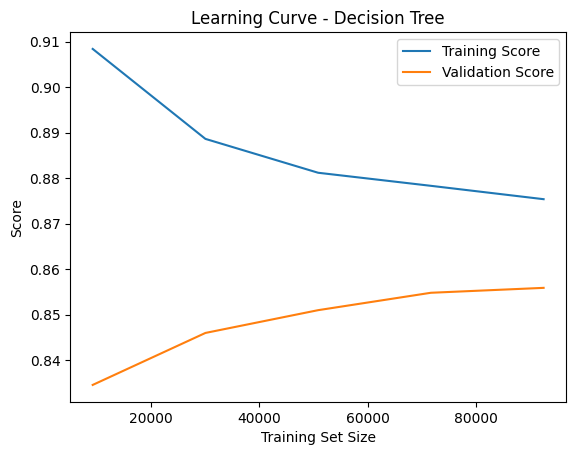

In [45]:
# 15c. Learning Curve – Decision Tree
train_sizes, train_scores, test_scores = learning_curve(best_dt, X_train, y_train, cv=5)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.title("Learning Curve - Decision Tree")
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.legend()
plt.show()

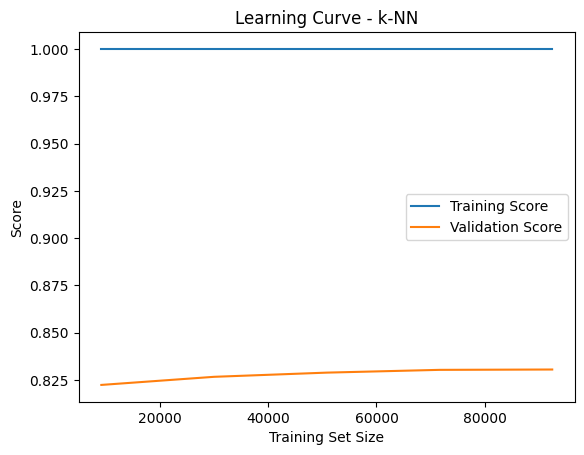

In [46]:
# 15d. Learning Curve – k-NN
train_sizes_knn, train_scores_knn, test_scores_knn = learning_curve(best_knn, X_train, y_train, cv=5)

plt.plot(train_sizes_knn, np.mean(train_scores_knn, axis=1), label='Training Score')
plt.plot(train_sizes_knn, np.mean(test_scores_knn, axis=1), label='Validation Score')
plt.title("Learning Curve - k-NN")
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.legend()
plt.show()


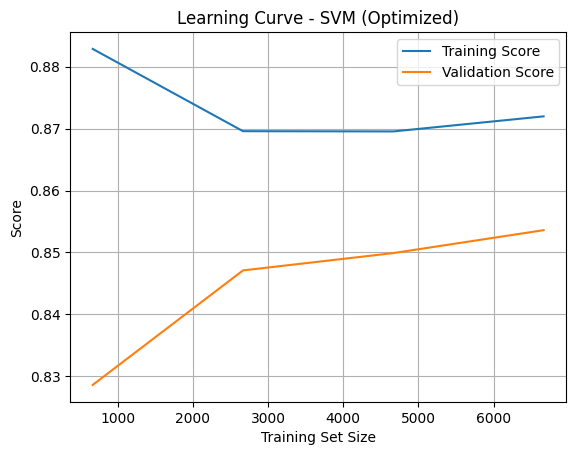

In [47]:
"""# 15e. Learning Curve – SVM
train_sizes_svm, train_scores_svm, test_scores_svm = learning_curve(best_svm, X_train, y_train, cv=5)

plt.plot(train_sizes_svm, np.mean(train_scores_svm, axis=1), label='Training Score')
plt.plot(train_sizes_svm, np.mean(test_scores_svm, axis=1), label='Validation Score')
plt.title("Learning Curve - SVM")
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.legend()
plt.show() """


from sklearn.svm import SVC
from sklearn.model_selection import learning_curve

# Modelo mais leve (sem probability)
fast_svm = SVC(C=1, kernel='rbf', gamma='scale', probability=False)  # Ajusta se os melhores params forem outros

# Subconjunto menor dos dados para acelerar
X_subset = X_train[:10000]
y_subset = y_train[:10000]

# Learning Curve otimizada
train_sizes_svm, train_scores_svm, test_scores_svm = learning_curve(
    estimator=fast_svm,
    X=X_subset,
    y=y_subset,
    cv=3,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 4)  # 4 tamanhos
)

# Gráfico
plt.plot(train_sizes_svm, np.mean(train_scores_svm, axis=1), label='Training Score')
plt.plot(train_sizes_svm, np.mean(test_scores_svm, axis=1), label='Validation Score')
plt.title("Learning Curve - SVM (Optimized)")
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()



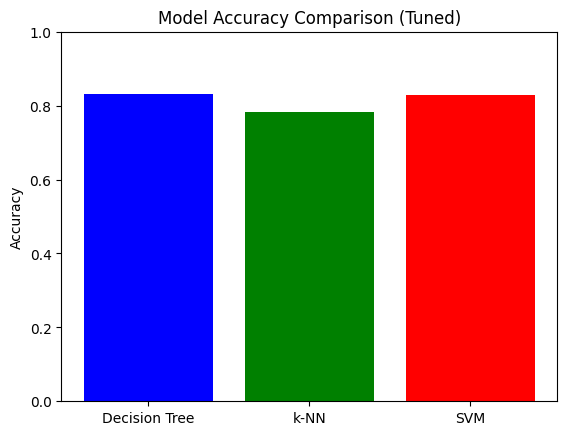

In [48]:
# 16. Gráfico comparativo
models = ['Decision Tree', 'k-NN', 'SVM']
accuracies = [accuracy_dt, accuracy_knn, accuracy_svm]

plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.title('Model Accuracy Comparison (Tuned)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


Métricas de Avaliação dos Modelos:
Decision Tree - Precisão: 0.5780, Recall: 0.7257, F1-Score: 0.6435, AUC-ROC: 0.8718
k-NN           - Precisão: 0.4853, Recall: 0.6799, F1-Score: 0.5664, AUC-ROC: 0.7974
SVM            - Precisão: 0.5707, Recall: 0.7386, F1-Score: 0.6438, AUC-ROC: 0.8567


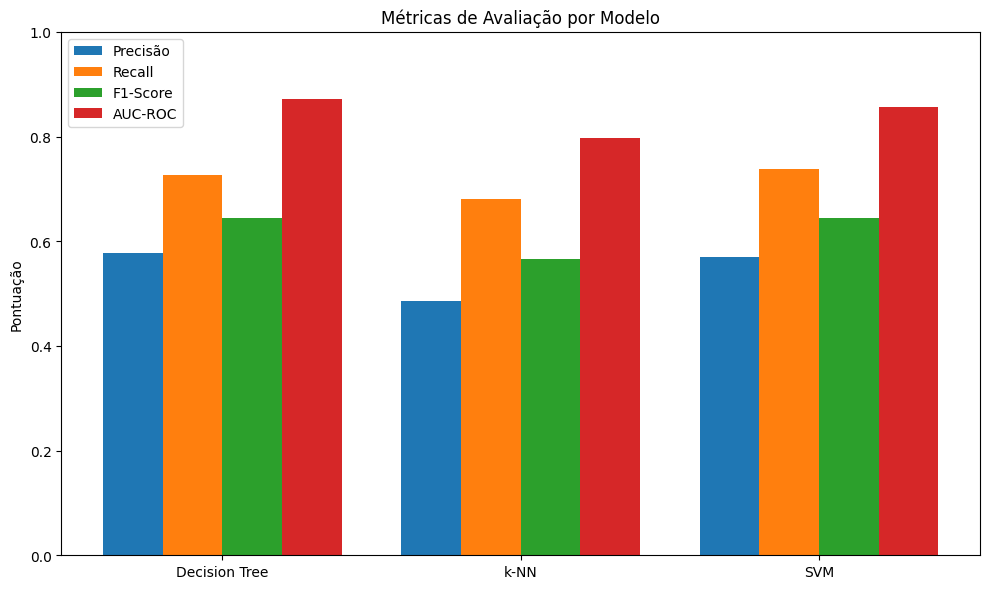

In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Decision Tree
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_prob_dt)

# k-NN
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)

# SVM
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)

print("\nMétricas de Avaliação dos Modelos:")
print(f"Decision Tree - Precisão: {precision_dt:.4f}, Recall: {recall_dt:.4f}, F1-Score: {f1_dt:.4f}, AUC-ROC: {roc_auc_dt:.4f}")
print(f"k-NN           - Precisão: {precision_knn:.4f}, Recall: {recall_knn:.4f}, F1-Score: {f1_knn:.4f}, AUC-ROC: {roc_auc_knn:.4f}")
print(f"SVM            - Precisão: {precision_svm:.4f}, Recall: {recall_svm:.4f}, F1-Score: {f1_svm:.4f}, AUC-ROC: {roc_auc_svm:.4f}")

import matplotlib.pyplot as plt
import numpy as np

# Dados para o gráfico
models = ['Decision Tree', 'k-NN', 'SVM']
precision_scores = [precision_dt, precision_knn, precision_svm]
recall_scores = [recall_dt, recall_knn, recall_svm]
f1_scores = [f1_dt, f1_knn, f1_svm]
roc_auc_scores = [roc_auc_dt, roc_auc_knn, roc_auc_svm]

x = np.arange(len(models))  # Posições das barras
width = 0.2  # Largura das barras

# Criar o gráfico
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5*width, precision_scores, width, label='Precisão')
rects2 = ax.bar(x - 0.5*width, recall_scores, width, label='Recall')
rects3 = ax.bar(x + 0.5*width, f1_scores, width, label='F1-Score')
rects4 = ax.bar(x + 1.5*width, roc_auc_scores, width, label='AUC-ROC')

# Adicionar detalhes ao gráfico
ax.set_ylabel('Pontuação')
ax.set_title('Métricas de Avaliação por Modelo')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [58]:
from sklearn.metrics import f1_score, roc_auc_score

# Cálculo do F1-Score
f1_dt = f1_score(y_test, y_pred_dt)
f1_knn = f1_score(y_test, y_pred_knn)
f1_svm = f1_score(y_test, y_pred_svm)

print(f"F1-Score Decision Tree: {f1_dt:.4f}")
print(f"F1-Score k-NN: {f1_knn:.4f}")
print(f"F1-Score SVM: {f1_svm:.4f}")

# Cálculo da AUC-ROC
roc_auc_dt = roc_auc_score(y_test, y_prob_dt)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)

print(f"AUC-ROC Decision Tree: {roc_auc_dt:.4f}")
print(f"AUC-ROC k-NN: {roc_auc_knn:.4f}")
print(f"AUC-ROC SVM: {roc_auc_svm:.4f}")


F1-Score Decision Tree: 0.6435
F1-Score k-NN: 0.5664
F1-Score SVM: 0.6438
AUC-ROC Decision Tree: 0.8718
AUC-ROC k-NN: 0.7974
AUC-ROC SVM: 0.8567


In [56]:
# 17. Mostrar os melhores parâmetros
print("\nBest Parameters for Each Model:")
print("Decision Tree:", grid_dt.best_params_)
print("k-NN:", grid_knn.best_params_)
print("SVM:", random_svm.best_params_)


Best Parameters for Each Model:
Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}
k-NN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
SVM: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}


In [50]:
# 18. Visualização dos resultados do GridSearchCV como tabela
results_dt = pd.DataFrame(grid_dt.cv_results_)
results_knn = pd.DataFrame(grid_knn.cv_results_)
results_svm = pd.DataFrame(random_svm.cv_results_)

print("\nTop 5 GridSearch Results - Decision Tree")
print(results_dt[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head())

print("\nTop 5 GridSearch Results - k-NN")
print(results_knn[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head())

print("\nTop 5 GridSearch Results - SVM")
print(results_svm[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head())


Top 5 GridSearch Results - Decision Tree
                                               params  mean_test_score
7   {'criterion': 'gini', 'max_depth': 10, 'min_sa...         0.813829
6   {'criterion': 'gini', 'max_depth': 10, 'min_sa...         0.813771
8   {'criterion': 'gini', 'max_depth': 10, 'min_sa...         0.813692
20  {'criterion': 'entropy', 'max_depth': 10, 'min...         0.813653
18  {'criterion': 'entropy', 'max_depth': 10, 'min...         0.813507

Top 5 GridSearch Results - k-NN
                                               params  mean_test_score
9   {'metric': 'manhattan', 'n_neighbors': 3, 'wei...         0.849705
11  {'metric': 'manhattan', 'n_neighbors': 5, 'wei...         0.849227
1   {'metric': 'euclidean', 'n_neighbors': 3, 'wei...         0.846823
13  {'metric': 'manhattan', 'n_neighbors': 7, 'wei...         0.846765
3   {'metric': 'euclidean', 'n_neighbors': 5, 'wei...         0.846755

Top 5 GridSearch Results - SVM
                                         

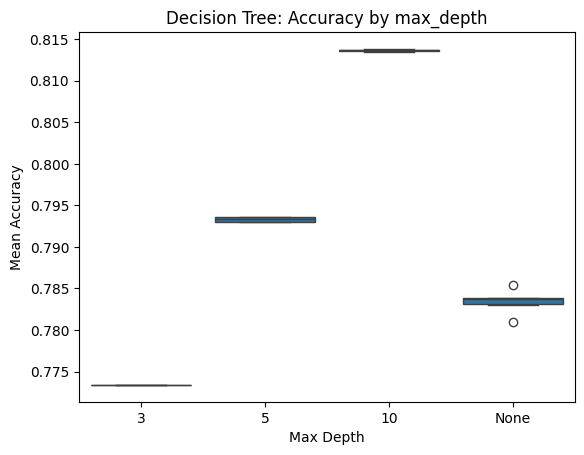

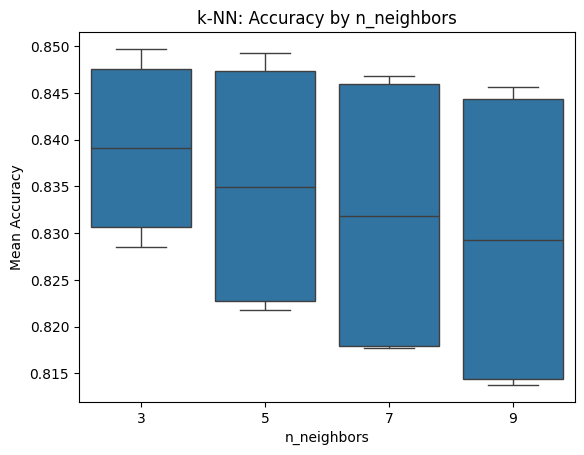

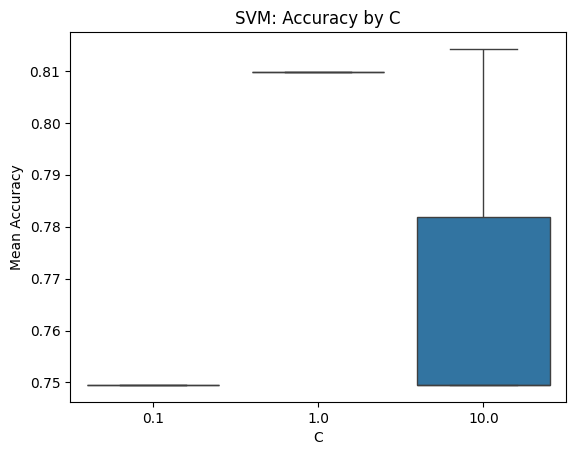

In [51]:
# 19. Visualizações dos parâmetros (exemplo com boxplot)
"""sns.boxplot(x='param_max_depth', y='mean_test_score', data=results_dt)
plt.title('Decision Tree: Accuracy by max_depth')
plt.xlabel('Max Depth')
plt.ylabel('Mean Accuracy')
plt.show()

sns.boxplot(x='param_n_neighbors', y='mean_test_score', data=results_knn)
plt.title('k-NN: Accuracy by n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('Mean Accuracy')
plt.show()

sns.boxplot(x='param_C', y='mean_test_score', data=results_svm)
plt.title('SVM: Accuracy by C')
plt.xlabel('C')
plt.ylabel('Mean Accuracy')
plt.show()""" 

# 19. Visualizações dos parâmetros (exemplo com boxplot)

# --- Decision Tree ---
# Converter None para string (necessário para evitar erro no eixo X do seaborn)
results_dt['param_max_depth'] = results_dt['param_max_depth'].astype(str)

sns.boxplot(x='param_max_depth', y='mean_test_score', data=results_dt)
plt.title('Decision Tree: Accuracy by max_depth')
plt.xlabel('Max Depth')
plt.ylabel('Mean Accuracy')
plt.show()

# --- k-NN ---
sns.boxplot(x='param_n_neighbors', y='mean_test_score', data=results_knn)
plt.title('k-NN: Accuracy by n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('Mean Accuracy')
plt.show()

# --- SVM ---
sns.boxplot(x='param_C', y='mean_test_score', data=results_svm)
plt.title('SVM: Accuracy by C')
plt.xlabel('C')
plt.ylabel('Mean Accuracy')
plt.show()


In [52]:
from sklearn.feature_selection import SelectKBest, f_classif

# Aplicar SelectKBest para selecionar as 10 melhores features
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)

# Obter os nomes das features selecionadas
selected_mask = selector.get_support()
selected_features = X.columns[selected_mask]

print("Top 10 features selecionadas pelo SelectKBest:")
print(selected_features)

# Opcional: transformar X_train e X_test com as features selecionadas
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)


Top 10 features selecionadas pelo SelectKBest:
Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')


In [53]:
from sklearn.feature_selection import SelectKBest, f_classif

# 8.1. Seleção de features mais relevantes com SelectKBest
# Seleciona as 10 melhores features com base no teste ANOVA F
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)  # aplica ao dataset normalizado

# Guardar os nomes das features selecionadas (opcional, útil para análise posterior)
selected_features_mask = selector.get_support()
selected_feature_names = X.columns[selected_features_mask]
print("Features selecionadas pelo SelectKBest:")
print(selected_feature_names)

# 9. Separar em treino e teste (com dados filtrados)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)


Features selecionadas pelo SelectKBest:
Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')


C:\Users\lara2\AppData\Local\Temp\ipykernel_38832\2178937812.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_scores, y=sorted_names, palette="viridis")


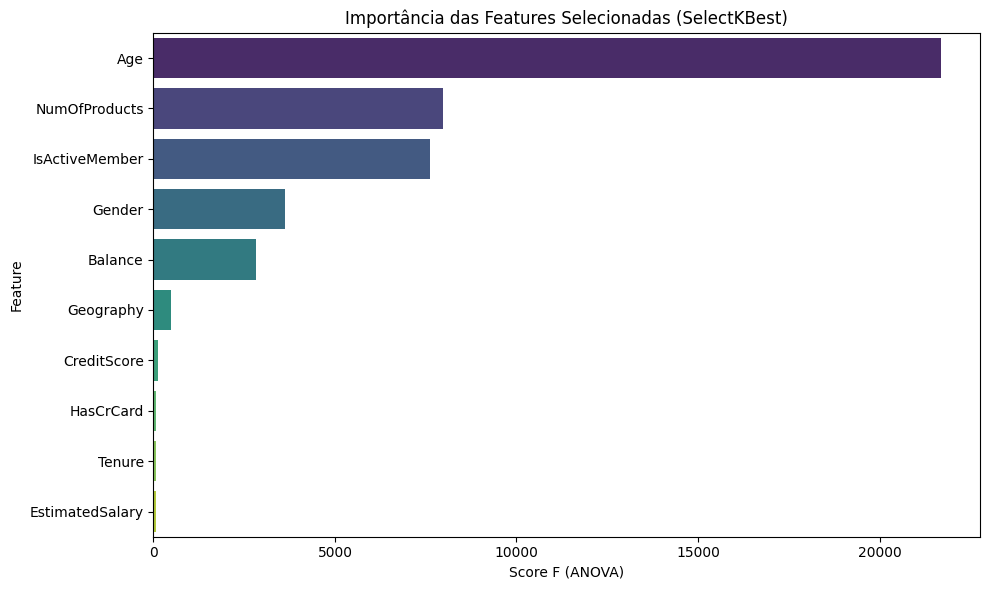